# Lecture 5 - Classification & Regression I (Evaluation)

Classification and regression are methods for predicting either class labels (classification) or numerical values (regression). Both methods work by find patterns between the input (sets of attribute/features) and the output labels or output values. This requires a dataset of many example of (input, output)-pairs from which to derive meaningful patterns.

In practice, having such a dataset is often the bigger challenge compared to applying mature classification and regression models. On the upside, existing (input, output)-pairs allows to evaluate models as those pairs provide ground truth to compare predictions to. 

Comparing the numerical output and predicted values in case of regression is typically a straightforward task using error function such as the (Root) Mean Squared Error (R)MSE. Less obvious is the comparison between ground truth and prediction in case of classifications. In this notebook, we look a bit closer into the evaluation of classification models.

Let's get started...


## Setting up the notebook

Specify how plots get rendered

In [1]:
%matplotlib notebook

Make all required imports.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn import preprocessing

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

## Working with Toy Data

We first start with some toy data containing 10 predictions (`y_pred`) of a binary classification task and the corresponding 10 ground truth labels (`y_true`). In this example, we assume that the predictions are not (directly) class labels 0 or 1 but numerical values reflecting the probability of Class 1.

In [3]:
y_pred = np.array([0.95, 0.3, 0.4, 0.55, 0.1, 0.45, 0.9, 0.6, 0.4, 0.65])
y_true = np.array([1, 0, 0, 0, 1, 1, 0, 1, 0, 1])

Based on a `threshold` we can map the probabilities into class labels. Since we only have to classes (i.e., binary classification) we can assign Class 1 to any prediction with a probability greater or equal to `threshold`; Class 0 otherwise. That's where easy to do with [np.qhere](https://numpy.org/doc/stable/reference/generated/numpy.where.html).

In [4]:
threshold = 0.6

y_pred_classes = np.where(y_pred >= threshold, 1, 0)

print('y_true = {}'.format(y_true))
print('y_pred = {}'.format(y_pred_classes))

y_true = [1 0 0 0 1 1 0 1 0 1]
y_pred = [1 0 0 0 0 0 1 1 0 1]


scikit-learn provide a handy method to evaluate the [`confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) with matrix element $A_{ij}$ representing the number of samples of Class $i$ predicted to Class $j$.

In case of binary classification, the confusion matrix is a 2x2 matrix and allows to directly, extract the number of true positives (TP), false positives (FP), false negative (FN), and true negatives (TN).

In [5]:
print(confusion_matrix(y_true, y_pred_classes))

# ravel() "flattens" the 2x2 matrix to directly have access to all 4 elements
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_classes).ravel()

print('TP: {}\nFP: {}\nFN: {}\nTN: {}'.format(tp, fp, fn, tn))

[[4 1]
 [2 3]]
TP: 3
FP: 1
FN: 2
TN: 4


You can visually confirm the correctness of the results. For example, `TP: 3` means that there a 3 samples where both `y_pred` and `y_true` have a 1 at the same position the arrays. You can change the `threshold` and see it's effect on the confusion matrix.

Another useful method provided by scitkit-learn is [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) that prints a basic summary of the evaluation results. This summary contains the precision, recall, and f1-score for each class (i.e., 1-vs-rest) as well as the averages over all classes.

In [6]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.75      0.60      0.67         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10



### Receiver Operating Characteristic (ROC)

We have seen above, that the choice of `threshold` can greatly affect the evaluation results. The common way to visualize the effect the choice of `threshold` on the results is by means of the Receiver Operating Characteristic (ROC) curce which plots the False Positive Rate (1-Specificity) against the True Positivity Rate (Sensitivity) for different thresholds.

Of course, scitkit-learn comes with a respective method [`roc_curve()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) that returns all FPRs and TPRs together with the respective threshold for a pair of prediction and ground truth labels. Note that this method also calculate all meaningful thresholds -- that is, the threshold that actually affect the FPR and TPR values.

In [7]:
# We don't need the thresholds for the plot
fpr, tpr, _ = roc_curve(y_true, y_pred)

The ROC curve is a useful visualization tool but does not provide a simple numerical values that would allow to compare different curves in a straightforward manner. To this end, we introduced the Area Under the Curve for the Receiver Operating Characteristic (AUC-ROC). Again, scitkit-learn has us covered with the method [`roc_auc_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).

In [8]:
roc_auc = roc_auc_score(y_true, y_pred)

With those values, we can plot the ROC curve as a basic line plot. The dashed line represent the ROC of a random classifier. We define a method for plotting as we can re-use it later.

In [9]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("False Positive Rate (1-Specificity)", fontsize=16)
    plt.ylabel("True Positive Rate (Sensitivity)", fontsize=16)
    line = plt.plot(fpr, tpr, marker='o', lw=3, markersize=10, label='ROC curve (area = {:.2f})'.format(roc_auc))[0]
    line.set_clip_on(False)
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()   

<IPython.core.display.Javascript object>


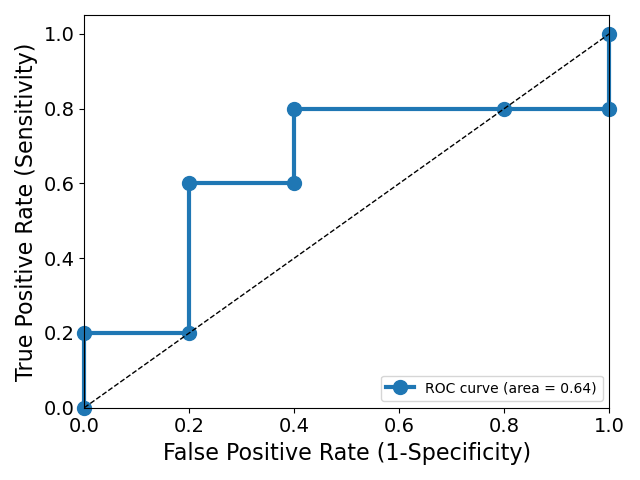

In [10]:
plot_roc_curve(fpr, tpr, roc_auc)

### ROC from Scratch

The method [`roc_curve()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) is the go-to tool in practice. However, to really understand the idea behind the ROC curve, it's best to implement from scratch to really see what's going on.

#### Calculate Sensitivity and Specificity

scikit-learn does not provide methods to directly get the sensitivity and specificity for a classifier. However, we can easily calculate both values based on the TP/FP/FN/TN values we get from scikit-learn.

In [11]:
def calc_roc_values(y_true, y_pred):
    # Get the individual tp/fp/fn/tn values
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # Calculate sensitivity
    sensitivity = tp / (tp + fn)
    # Calculate specificity
    specificity = tn / (tn + fp)
    # Return both values
    return sensitivity, specificity

Try the method for different thresholds and see how the sensitivity and specificity changes.

In [12]:
threshold = 0.5

y_pred_classes = np.where(y_pred >= threshold, 1, 0)

sensitivity, specificity = calc_roc_values(y_true, y_pred_classes)

print('Sensitivity: {}\nSpecificity: {}'.format(sensitivity, specificity))

Sensitivity: 0.6
Specificity: 0.6


#### Calculate ROC¶

Calculating the ROC involves two steps:

* Calculate all meaningful thresholds (meaningful = will affect the results)
* Calculate false-positive rate and true-positive rate for each threshold

In [13]:
def eval_roc(y_true, y_pred):
    
    #############################################################################
    ## Calculate all "meaningful" thresholds
    #############################################################################
    
    # Get unique predicted values (result is conveniently sorted)
    values = np.unique(y_pred)
    
    # Add 0 at the beginning and 1.0 at the end
    values = np.insert(values, 0, 0.0)
    values = np.insert(values, values.shape[0], 1.0)
    
    # Calculate thresholds as the average of all subsequent value pairs
    # Only the value between two sample values make meaningful thresholds
    thresholds = np.array([(values[i]-values[i-1])/2 + values[i-1] for i, _ in enumerate(values) if i > 0])
    
    #############################################################################
    ## Calculate false-positive rate and true-positive rate for each threshold
    #############################################################################
    fpr, tpr = [], []
    
    for t in thresholds:
        # Convert probilities to class labels
        y_pred_classes = np.where(y_pred >= t, 1, 0)
        # Calculate sensitivity and specificity
        sensitivity, specificity = calc_roc_values(y_true, y_pred_classes)
        # Keep track of false positive and true positive rates
        fpr.append(1-specificity)
        tpr.append(sensitivity)
        
    # Return arrays with false-postive rates and true-positive rates
    return fpr, tpr

No we can call `eval_roc()` the same way as we did `roc_curve()`; note that `eval_roc()` does not return the used threshold as we don't really need them.

In [14]:
fpr, tpr = eval_roc(y_true, y_pred)

# We use the scikit-learn method for calculating the AUC-ROC
roc_auc = roc_auc_score(y_true, y_pred)

<IPython.core.display.Javascript object>


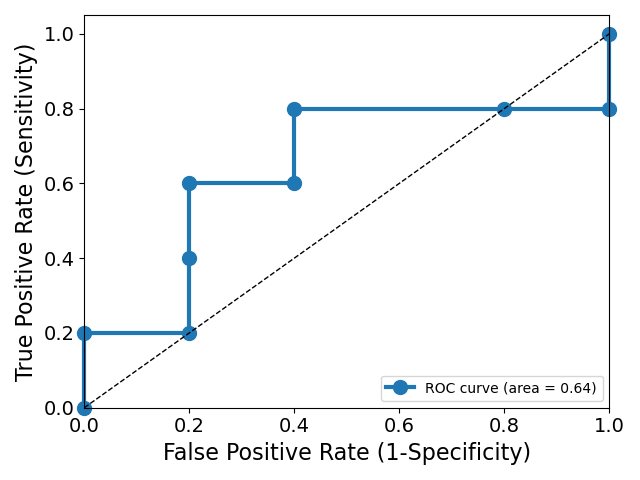

In [15]:
plot_roc_curve(fpr, tpr, roc_auc)

Of course, the overall shape of both ROC curves is the same. Note, however, that `eval_roc()` returns 1 more FPR/TPR value at `(0.2, 0.4)`. This is because we didn't optimize the set of meaningful thresholds, but used a simple heuristic. This does not change the results but of course can effect the efficiency as more threshold than needed are checked.

## Real-World Data: Diabetes Dataset

We are now ready to look at some real-world dataset, but still simple one to help understanding. The first dataset contains medical records of people with a binary output variable stating whether a person suffers from diabetes or not.

### Load and Prepare the Data

In [16]:
df_diabetes = pd.read_csv('data/diabetes.csv')

# The rows are sorted, so let's shuffle them
df_diabetes = df_diabetes.sample(frac=1).reset_index(drop=True)

# Show the first 5 columns
df_diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,96,68,13,49,21.1,0.647,26,0
1,0,123,88,37,0,35.2,0.197,29,0
2,2,117,90,19,71,25.2,0.313,21,0
3,3,158,70,30,328,35.5,0.344,35,1
4,8,151,78,32,210,42.9,0.516,36,1


### Create Training and Test Data

The basic setup of classification and regression task is to split the dataset into training and test data. A 80%/20% split is very common.

In [17]:
# Convert data to numpy arrays
X = df_diabetes[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']].to_numpy()
y = df_diabetes[['Outcome']].to_numpy().squeeze()

# Let's go for a 80%/20% split -- you can change the value anf see its effects
train_test_ratio = 0.80

# Calculate the size of the training data (the size of the dest data is also implicitly given)
train_set_size = int(train_test_ratio * len(X))

# Split data and labels into training and test data with respect to the size of the test data
X_train, X_test = X[:train_set_size], X[train_set_size:]
y_train, y_test = y[:train_set_size].squeeze(), y[train_set_size:].squeeze()

print("Size of training set: {}".format(len(X_train)))
print("Size of test: {}".format(len(X_test)))

Size of training set: 614
Size of test: 154


Although we have only numerical values as input attributes there magnitudes and ranges differ noticeable. It's therefore a good idea to normalize/standardize the data. Feel free to skip this step and compare the results.

As usual, scitkit-learn makes it very convenient by providing a [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) (among other methods for normalization and standardization).

In [18]:
# We fit the scaler based on the training data only
scaler = preprocessing.StandardScaler().fit(X_train)

# Of course, we need to convert both training and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Train a Classifier Using Training Data

As we use, off-the-shelf implementations of different classifiers, the training is extremely simple. Not that we consider classifiers here that (optionally) return probabilities not not just class labels. The only reason for this is to plot the ROC curves.

In [19]:
clf = LogisticRegression().fit(X_train, y_train)
#clf = RandomForestClassifier().fit(X_train, y_train)
#clf = DecisionTreeClassifier().fit(X_train, y_train)

### Evaluation

For the evaluation, we can use all the methods we introduced above for our toy dataset.

#### Classes/labels

The method `predict()` directly returns class labels. All classifier provides this methods. This allows us to directly print the confusion matrix and the classification report.

In [20]:
y_pred = clf.predict(X_test)

In [21]:
print(confusion_matrix(y_test, y_pred))

[[96  7]
 [20 31]]


In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       103
           1       0.82      0.61      0.70        51

    accuracy                           0.82       154
   macro avg       0.82      0.77      0.79       154
weighted avg       0.82      0.82      0.82       154



#### Probabilities

The method `predict_proba()` returns the probabilities of class labels. Only classifiers that by their definition return probabilities offer this method. Not that each entry returns the probabilities for each class. For example, for binary classification, each entry comes with 2 probabilities. Naturally, all probabilities for each entry sum up to 1.

In [23]:
y_pred = clf.predict_proba(X_test)

# As we have a binary task, we can focus on the probability for Class 1.
y_pred = y_pred[:,1]

We have now everything in place to plot the ROC curve and calculate the AUC-ROC values

<IPython.core.display.Javascript object>


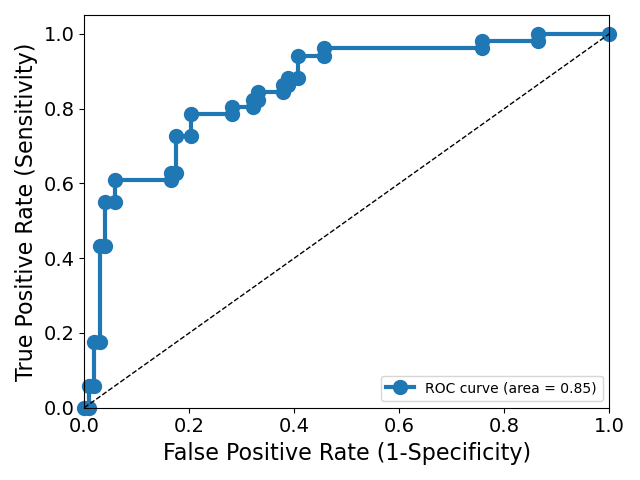

In [24]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
plot_roc_curve(fpr, tpr, roc_auc)

## Real-World Data: IRIS Dataset

As a second real-world example, we use the IRIS data. While it's smaller than the Diabetes dataset with less features, it comes with 3 classes, so we can look how to handle cases beyond binary classification tasks.

### Load the Data

In [25]:
df = pd.read_csv('data/iris.csv')

# Convert the species name to numerical categories 0, 1, 2
df['species'] = pd.factorize(df['species'])[0]

# The rows are sorted, so let's shuffle them
df = df.sample(frac=1).reset_index(drop=True)

# Show the first 5 columns
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.4,1.5,0.2,0
1,5.0,3.5,1.6,0.6,0
2,6.0,3.4,4.5,1.6,1
3,5.8,2.7,4.1,1.0,1
4,5.5,2.6,4.4,1.2,1


### Create Training and Test Data

Same as above, we split the dataset into training and test data. Note that we introduce some noise in therms of additional features with random noise. Otherwise, this dataset is too "clean" and most classifiers will work almost perfectly. Feel free to remove the adding of the noise and compare the results.

In [26]:
# Convert data to numpy arrays
X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].to_numpy()
y = df[['species']].to_numpy()

print('The original dataset has {} samples, each with {} features'.format(X.shape[0], X.shape[1]))

# The classification task over the original IRIS dataset is too easy, most classifiers perform perfectly
# We therefore add noise in terms of additional 50 features with random values
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.concatenate((X, random_state.randn(n_samples, 50 * n_features)), axis=1)

print('The modified dataset has {} samples, each with {} features'.format(X.shape[0], X.shape[1]))

# Let's go for a 80%/20% split -- you can change the value anf see its effects
train_test_ratio = 0.8

# Calculate the size of the training data (the size of the dest data is also implicitly given)
train_set_size = int(train_test_ratio * len(X))

# Split data and labels into training and test data with respect to the size of the test data
X_train, X_test = X[:train_set_size], X[train_set_size:]
y_train, y_test = y[:train_set_size].squeeze(), y[train_set_size:].squeeze()

print("Size of training set: {}".format(len(X_train)))
print("Size of test: {}".format(len(X_test)))
print(y_train.shape)

The original dataset has 150 samples, each with 4 features
The modified dataset has 150 samples, each with 204 features
Size of training set: 120
Size of test: 30
(120,)


We only need to standardize the data because of the noise we added. The original data has only features that all represent lengths in cm and are of comparable magnitude.

In [27]:
# We fit the scaler based on the training data only
scaler = preprocessing.StandardScaler().fit(X_train)

# Of course, we need to convert both training and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Train a Classifier

For multiclass classification task there are two approaches to train a classifier:

* Most classifier implementations directly support multiclass datasets. Here the training "looks" the same as for the case of binary classification

* [`OneVsRestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) explicitly implement the 1-vs-rest training strategy for the given type of classifier.

Try both methods and compare the differences -- which should be that large, in general

In [28]:
clf = LogisticRegression().fit(X_train, y_train)
#clf = RandomForestClassifier().fit(X_train, y_train)

clf = OneVsRestClassifier(LogisticRegression()).fit(X_train, y_train)
#clf = OneVsRestClassifier(RandomForestClassifier()).fit(X_train, y_train)


### Evaluation

#### Labels/classes

The method `predict()` directly returns class labels. All classifier provides this methods. This allows us to directly print the confusion matrix and the classification report.

In [29]:
y_pred = clf.predict(X_test)

In [30]:
print(confusion_matrix(y_test, y_pred))

[[10  0  0]
 [ 4  4  4]
 [ 0  3  5]]


In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.57      0.33      0.42        12
           2       0.56      0.62      0.59         8

    accuracy                           0.63        30
   macro avg       0.61      0.65      0.61        30
weighted avg       0.61      0.63      0.60        30



#### Probabilities

The method `predict_proba()` returns the probabilities of class labels. Only classifiers that by their definition return probabilities offer this method. Not that each entry returns the probabilities for each class. For example, for binary classification, each entry comes with 2 probabilities. Naturally, all probabilities for each entry sum up to 1.

In [32]:
y_pred = clf.predict_proba(X_test)

print(y_pred[:5])

[[0.99418234 0.00396491 0.00185275]
 [0.10953749 0.40505592 0.48540659]
 [0.93254913 0.06228774 0.00516313]
 [0.94413171 0.04905555 0.00681274]
 [0.00382403 0.0760841  0.92009187]]


Since we 3 classes, for plotting the ROC curves, we have use the 1-vs-rest approach. For each class, we consider only the respective probability.

In [33]:
fp_rates, tp_rates, roc_auc_scores = [], [], []

for c in [0, 1, 2]:
    # Get the probabilities for the current class
    y_pred_one = y_pred[:,c]
    # Convert to probabilities to class labels (as it's not 1-vs-rest, we only have the labels 0 and 1 now!!!)
    y_test_one = np.where(y_test==c, 1 , 0)

    # Calculate the false positive and true positive rates, as well as the AUC-ROC values
    fpr, tpr, _ = roc_curve(y_test_one, y_pred_one)
    roc_auc = roc_auc_score(y_test_one, y_pred_one)
    
    # Keep track for the results for each class
    fp_rates.append(fpr)
    tp_rates.append(tpr)
    roc_auc_scores.append(roc_auc)

We now have 3 ROC curves, so we cannot re-use the `plot_roc_curve()` here. The basic implementation is the same, apart from the 3 line plots now. (Well, we could generate 3 different plot, one for each curve, but having them in the same plot makes it easier to compare the different classes.)

<IPython.core.display.Javascript object>


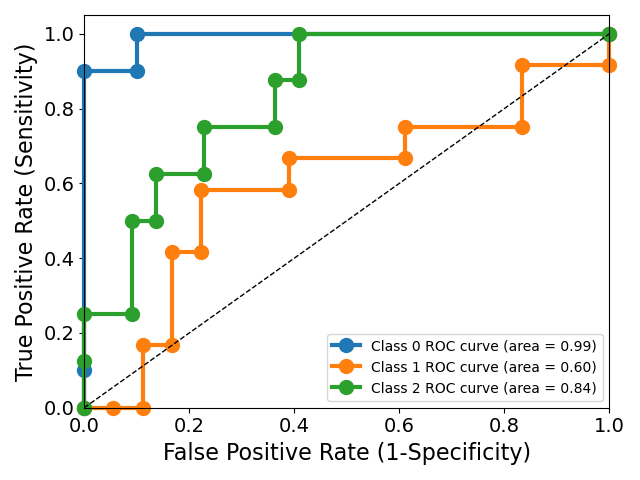

In [34]:
plt.figure()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("False Positive Rate (1-Specificity)", fontsize=16)
plt.ylabel("True Positive Rate (Sensitivity)", fontsize=16)

for c in [0, 1, 2]:
    line = plt.plot(fp_rates[c], tp_rates[c], marker='o', lw=3, markersize=10, label='Class {} ROC curve (area = {:.2f})'.format(c, roc_auc_scores[c]))[0]
    line.set_clip_on(False)
    
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show() 

As the plot shows, different classes are easier or more difficult to predict; the details depend in the random noise added to the data. If you remove the noise (see above) the result will be much better, almost perfect -- and a bit boring for this notebook.

## Summary

The availability of ground truth information in the context of classification and regression tasks enables the evaluation of classification and regression models. In this notebook, we looked a the most common techniques to evaluate classifiers -- since the evaluation of regressors is more straightforward.

In data mining and machine learning literature, you will see recall, precision and f1-score most commonly. Even if a classifier return probabilities, there's usually a 1:1 mapping to class labels assume where the class with the highest probability determines the label (independent from any threshold settings). However, it's still import to be able to interpret ROC curves and AUR-ROC values.